<a href="https://colab.research.google.com/github/HussainBaalbaki/NEA/blob/Master/SSigma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U -q tensorflow tensorflow_datasets

In [ ]:
import os
import pathlib
import gdown
import zipfile
import pandas as pd
from imblearn.over_sampling import SMOTE
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from sklearn.utils import resample
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import regularizers
from IPython import display

#  the seed value for  reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DATASET_PATH = 'drive/My Drive/data'

data_dir = pathlib.Path(DATASET_PATH)

commands = ['WakeWord', 'environmentnoise']
print('Commands:', commands)

def load_audio_file(file_path):
    audio_binary = tf.io.read_file(file_path)


    if file_path.endswith('.wav'):
        audio, sample_rate = tf.audio.decode_wav(audio_binary)
    elif file_path.endswith('.mp3'):
        raise NotImplementedError("ERROR 1-CHECK files type")
    else:
        raise ValueError(f"Unsupported file format: {file_path}")
    return audio, sample_rate

def preprocess(file_path):
    audio, sample_rate = load_audio_file(file_path)
    return audio

commands = ['WakeWord', 'environmentnoise']
print('Commands:', commands)

Mounted at /content/drive
Commands: ['WakeWord', 'environmentnoise']
Commands: ['WakeWord', 'environmentnoise']


In [ ]:
Batch_size=1200
Validation_split=0.4
Output_sequence_length=16000

train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=Batch_size,
    validation_split=Validation_split,
    seed=0,
    output_sequence_length=Output_sequence_length,
    subset='both',
    labels='inferred',
    class_names=commands
)

Found 6585 files belonging to 2 classes.
Using 3951 files for training.
Using 2634 files for validation.


In [ ]:
def load_dataset():
    dataset = tf.keras.utils.audio_dataset_from_directory(
        directory=data_dir,
        batch_size=64,
        validation_split=0.2,
        seed=0,
        output_sequence_length=16000,
        subset='both',
        labels='inferred'
    )

label_names = np.array(train_ds.class_names)
print()
print("Label names:", label_names)



Label names: ['WakeWord' 'environmentnoise']


In [ ]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

In [ ]:
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [ ]:
def get_spectrogram(waveform, frame_length=255, frame_step=128, desired_shape=(125, 125)):
  spectrogram = tf.signal.stft(
      waveform, frame_length=frame_length, frame_step=frame_step)
  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]

  spectrogram = tf.image.resize(spectrogram, desired_shape)
  return spectrogram

for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(1200, 16000)
(1200,)


In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    spectrogram = np.squeeze(spectrogram, axis=-1)
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

In [ ]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
    break


In [ ]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = 1


Input shape: (125, 125, 1)


In [ ]:
norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))


In [ ]:

model = models.Sequential([
    layers.Input(shape=input_shape),

    # Resize the input images to 32x32 pixels
    layers.Resizing(32, 32),

    # Normalization layer to scale input data
    norm_layer,

    # Convolutional Block 1 with L2 regularization and Dropout
    layers.Conv2D(32, 3, activation='relu', kernel_regularizer=regularizers.l2(0.007)),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),  # Increased dropout rate to 0.3 (edit12)
    norm_layer,

    # Flattening the output of the convolutional layers
    layers.Flatten(),
    # Dense Block with Dropout and L2 regularization
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.007)),
    layers.Dropout(0.5),  # Increased dropout rate to 0.5
    # Output layer with sigmoid activation for binary classification
    layers.Dense(num_labels, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 15, 15, 32)          │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 15, 15, 32)          │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 7200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         460,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 461,252 (1.76 MB)

 Trainable params: 461,249 (1.76 MB)

 Non-trainable params: 3 (16.00 B)

In [ ]:
model.compile(                                                                    # Binary loss function difference between the true labels "WakeWord", "enviromentnoise" and prediction
    optimizer=tf.keras.optimizers.Adam(),                                         # sigma function fr add images of the function + explination
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

In [ ]:
class_weights = {0: 1.0, 1: 22.0}

EPOCHS = 15

history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    class_weight=class_weights,
    ##callbacks=[early_stopping_callback],
)


Epoch 1/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6654 - loss: 1.0561 - val_accuracy: 0.6517 - val_loss: 0.7290
Epoch 2/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6662 - loss: 1.0439 - val_accuracy: 0.6517 - val_loss: 0.7183
Epoch 3/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6617 - loss: 1.1116 - val_accuracy: 0.6517 - val_loss: 0.7370
Epoch 4/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6655 - loss: 1.0936 - val_accuracy: 0.6517 - val_loss: 0.6786
Epoch 5/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6559 - loss: 1.0793 - val_accuracy: 0.6517 - val_loss: 0.6975
Epoch 6/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6652 - loss: 1.0619 - val_accuracy: 0.6517 - val_loss: 0.7441
Epoch 7/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6667 - loss: 1.0308 - val_accuracy: 0.6517 - val_loss: 0.6821
Epoch 8/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6539 - loss: 1.0488 - val_accuracy: 0.6517 - val_loss: 0.7420


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6874 - loss: 0.6519


{'accuracy': 0.6868898272514343, 'loss': 0.6529470086097717}

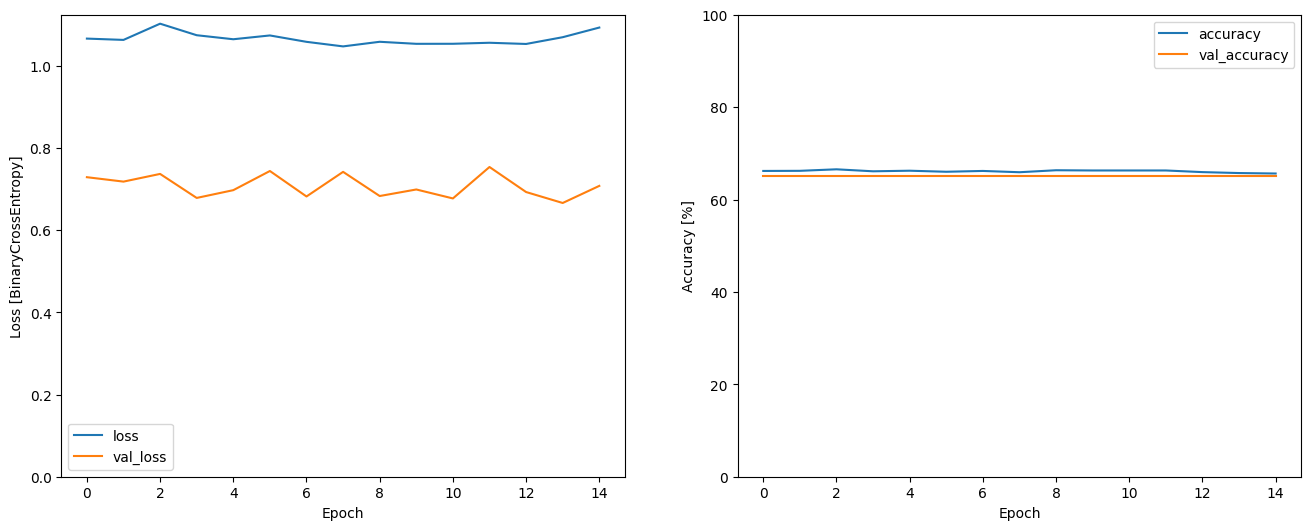

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [BinaryCrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

model.evaluate(test_spectrogram_ds, return_dict=True)

In [ ]:
y_pred = model.predict(test_spectrogram_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step


In [ ]:
y_pred = tf.argmax(y_pred, axis=1)

In [ ]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s, lab: lab)), axis=0)

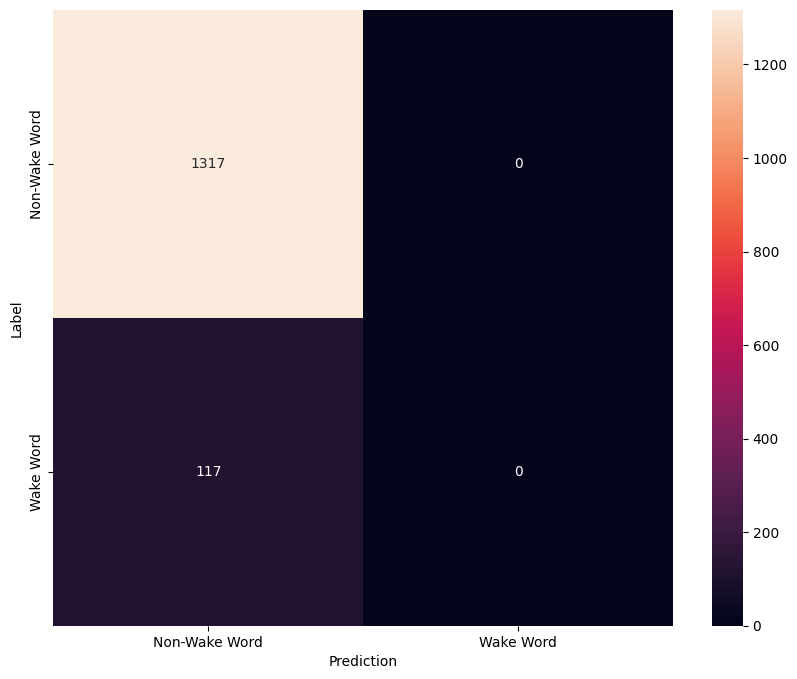

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=['Non-Wake Word', 'Wake Word'],
            yticklabels=['Non-Wake Word', 'Wake Word'],
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
x = data_dir/'WakeWord/david_20240831_014725_louder - Copy (5) - Copy.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]


In [ ]:
prediction = model(x)
print(f'Prediction: {tf.round(prediction).numpy()} (0=Non-Wake Word, 1=Wake Word)')
display.display(display.Audio(waveform, rate=16000))


Prediction: [[0.]] (0=Non-Wake Word, 1=Wake Word)


In [ ]:
class ExportModel(tf.Module):
    def __init__(self, model):
        self.model = model
        self.__call__.get_concrete_function(
            x=tf.TensorSpec(shape=(), dtype=tf.string))
        self.__call__.get_concrete_function(
           x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))

In [ ]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model
    self.__call__.get_concrete_function(x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))

  @tf.function
  def __call__(self, x):
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)
    result = self.model(x, training=False)

    class_id = tf.round(result)  # Output 0 or 1
    return {'predictions': result, 'class_id': class_id}


In [ ]:
export = ExportModel(model)
tf.saved_model.save(export, "saved_model")

imported = tf.saved_model.load("saved_model")
imported(waveform[tf.newaxis, :])


model.save('my_model.keras')

ValueError: Unable to synchronously create group (name already exists)